# Backtesting Single SMA(30) Strategy

## Importing Libraries

In [1]:
import pandas as pd
import yfinance as yf
import backtrader as bt
import backtrader.feeds as btfeeds
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 8)
%matplotlib inline


## Data Acquisition

Using Yahoo Finance API

In [2]:
data = yf.download('GC=F', start='2020-01-01', end='2024-01-01')

[*********************100%***********************]  1 of 1 completed


Converting data into CSV file

In [3]:
data.to_csv('GOLD_data.csv')

Data exploration

In [4]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,1518.099976,1528.699951,1518.000000,1524.500000,1524.500000,214
2020-01-03,1530.099976,1552.699951,1530.099976,1549.199951,1549.199951,107
2020-01-06,1580.000000,1580.000000,1560.400024,1566.199951,1566.199951,416
2020-01-07,1558.300049,1576.300049,1558.300049,1571.800049,1571.800049,47
2020-01-08,1579.699951,1604.199951,1552.300049,1557.400024,1557.400024,236


In [5]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1007.000000,1007.000000,1007.000000,1007.000000,1007.000000,1007.000000
mean,1828.224827,1837.602384,1819.079146,1828.325718,1828.325718,4385.268123
std,114.159337,113.764866,114.653137,114.046079,114.046079,24057.326026
min,1469.300049,1484.000000,1452.099976,1477.300049,1477.300049,0.000000
25%,1759.050049,1767.200012,1749.900024,1757.799988,1757.799988,83.000000
50%,1826.099976,1833.900024,1817.500000,1828.699951,1828.699951,248.000000
75%,1920.049988,1927.550049,1911.549988,1919.099976,1919.099976,666.000000
max,2081.600098,2130.199951,2066.500000,2081.899902,2081.899902,251274.000000


### Data Cleaning

Looking for missing values

In [6]:
data.isna().any()

Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

Looking for duplicates

In [7]:
data.duplicated().any()

np.False_

### SMA Strategy Definition

Here we implement a simple moving average (SMA) strategy using a 30-period SMA on the asset's closing price.
- **Buy Signal**: Triggers when the closing price crosses above the 30-period SMA.

- **Sell Signal**: Triggers when the closing price crosses below the 30-period SMA.

- **Position Management**: Opens a long position on a buy signal and a short position on a sell signal. Closes positions when the opposite signal is generated.
  
- **Objective**: Designed to capitalize on short-term trends by following price movements relative to the SMA.

In [8]:
class SMAStrategy(bt.SignalStrategy):
    def __init__(self):

        #Define moving average (30 periods)
        self.sma30 = bt.indicators.SimpleMovingAverage(self.data.close, period=30)

        #Add buy/sell signals
        self.signal_add(bt.SIGNAL_LONG, self.data.close > self.sma30)
        self.signal_add(bt.SIGNAL_SHORT, self.data.close < self.sma30)

    def next(self):
        
        # Check if there are open positions
        if not self.position:
            # If there is no position, check for a buy/sell signal
            if self.data.close > self.sma30:
                self.buy()  # Open a long position
            elif self.data.close < self.sma30:
                self.sell()  # Open a short position
        else:
            # If there is a position, close it if the opposite signal is triggered
            if self.position.size > 0 and self.data.close < self.sma30:
                self.close()  # Close long position
            elif self.position.size < 0 and self.data.close > self.sma30:
                self.close()  # Close short position



### Backtesting Configuration & Execution

This function prompts the user to input custom start and end dates for the backtesting period.
It ensures that the start date is earlier than the end date, converting the inputs to Pandas Timestamps.


In [9]:
def dateask():
    start_date = input('Introduce Start Date (YYYY-MM-DD): ')
    end_date = input('Introduce End Date (YYYY-MM-DD): ')

    if start_date > end_date:
        print('Start date must be earlier than End date')
        dateask()
    else:
        start_date = pd.Timestamp(start_date)
        end_date = pd.Timestamp(end_date)

    
    return start_date, end_date

In [10]:
#Uncoment line bellow and comment 'date1' and 'date2' lines if wanted to introduce other dates
#date1, date2 = dateask()

# Default Dates to use if not executing .ipynb on computer
date1 = pd.Timestamp('2022-01-01')
date2 = pd.Timestamp('2023-12-01')

cerebro = bt.Cerebro()

#Add strategy to cerebro
cerebro.addstrategy(SMAStrategy)

#Upload data
datafeed = btfeeds.YahooFinanceCSVData(dataname='GOLD_data.csv', fromdate=date1, todate=date2)
cerebro.adddata(datafeed)

#Set initial capital
cerebro.broker.set_cash(100000)

#Set order size
cerebro.addsizer(bt.sizers.FixedSize, stake=50)

### Backtesting Results

In [11]:
#Execute backtesting
starting_balance = cerebro.broker.getvalue()
cerebro.run()
ending_balance = cerebro.broker.getvalue()

#(Provisional table output via print(). Currently working on a function to streamline the process)
print(f'+---------------------------+\n| Starting Portfolio Value  |\n| {starting_balance} $                |')
print(f'+---------------------------+\n| Ending Portfolio Value    |\n| {ending_balance} $                |')
print('+---------------------------+')

+---------------------------+
| Starting Portfolio Value  |
| 100000 $                |
+---------------------------+
| Ending Portfolio Value    |
| 107435.0 $                |
+---------------------------+


### Backtest Plot

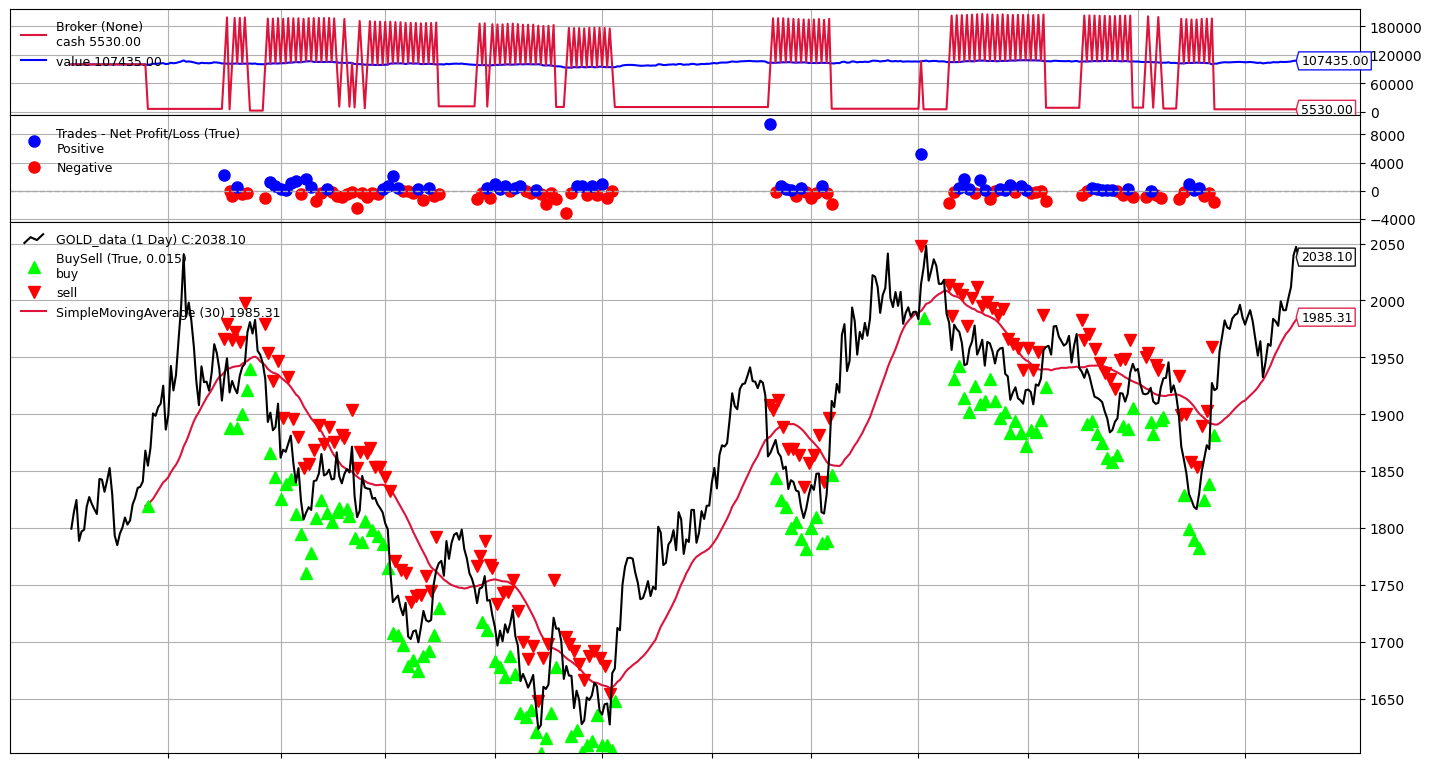

[[<Figure size 1500x800 with 3 Axes>]]

In [12]:
cerebro.plot(iplot=False, volume=False)